## Dependencies

In [1]:
import math, PIL
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
from melanoma_utility_scripts import *

# Model parameters

In [2]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "AUGMENTED_SAMPLES": 5,
  "COLUMNS": 10,
  "DATASET_PATH": 'melanoma-256x256'
}

config

{'HEIGHT': 256,
 'WIDTH': 256,
 'CHANNELS': 3,
 'AUGMENTED_SAMPLES': 5,
 'COLUMNS': 10,
 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(database_base_path + 'train.csv')

print('Train samples: %d' % len(train))
display(train.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TRAINING_FILENAMES = TRAINING_FILENAMES[1] # sample

Train samples: 33126


image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

# Augmentations

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_pixel >= .2: # Pixel-level transforms
      if p_pixel >= .75:
        image = data_augment_saturation(image)
      elif p_pixel >= .5:
        image = data_augment_contrast(image)
      else:
        image = data_augment_brightness(image)

    if p_rotation >= .2: # Rotation
      image = data_augment_rotation(image)

    if p_spatial2 >= .2: 
      if p_spatial2 >= .6: # Shift
        image = data_augment_shift(image)
      else: # Shear
        image = data_augment_shear(image)
        
    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image = data_augment_spatial(image)
      else: # Rotate
        image = data_augment_rotate(image)

    if p_crop >= .2: # Crops
      image = data_augment_crop(image)
    
    if p_cutout >= .2: # Cutout
      image = data_augment_cutout(image)
    
    return image


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .5:
        if p_crop > .9:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop > .7:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        else:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [5]:
# Datasets utility functions
LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "target": tf.io.FixedLenFeature([], tf.int64), # shape [] means single element
}

def decode_image(image_data, height, width, channels):
    image = tf.image.decode_jpeg(image_data, channels=channels)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, channels])
    return image

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    
#     return image, label
    return image

def load_dataset(filenames, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_display(filenames):
    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval,)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_display_dataset(filenames, batch_size=32):
    dataset = load_dataset_display(filenames)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    return dataset

def display_augmentation(dataset, n_samples, augmentation, rows=1, cols=8):
    dataset_elements = iter(dataset)
    for sample in range(n_samples):
        element = tf.data.Dataset.from_tensors(next(dataset_elements))
        element_augmented = element.repeat().map(augmentation).batch(rows*cols)
        for img in element_augmented:
            plt.figure(figsize=(15, int(15*rows/cols)))
            for j in range(rows*cols):
                plt.subplot(rows, cols, j+1)
                plt.axis('off')
                plt.imshow(img[j,])
            plt.show()
            break
            
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
    for idx, data in enumerate(ds):
        img = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

# Display images

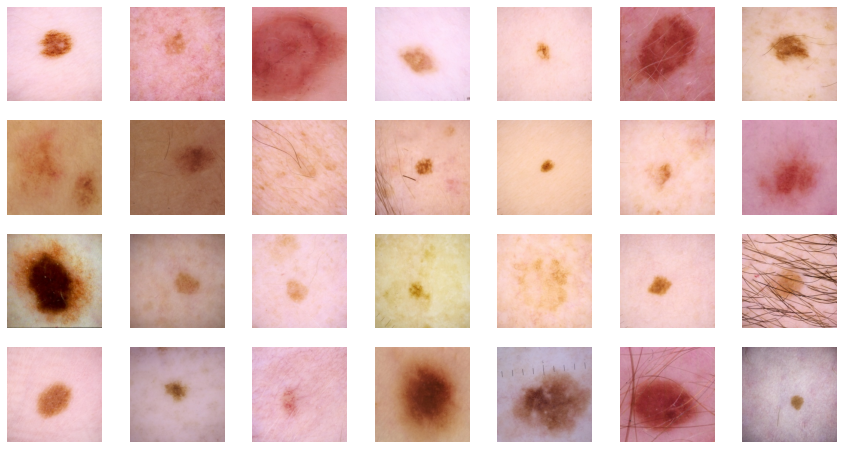

In [6]:
row = 4; col = 7;
all_elements = get_display_dataset(TRAINING_FILENAMES).unbatch()
batch_element = all_elements.repeat().batch(row*col)

for img in batch_element:
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# Spatial augmentation

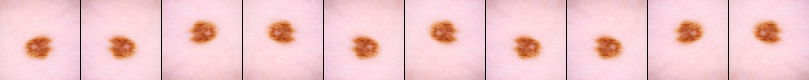

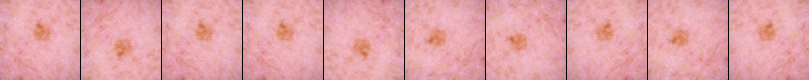

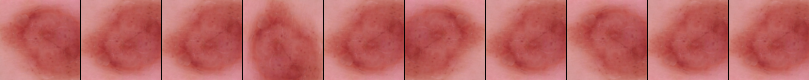

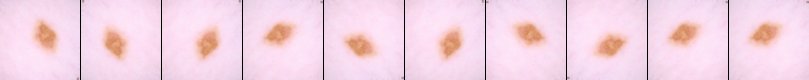

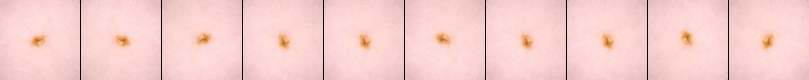

In [7]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_spatial(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Rotates augmentation

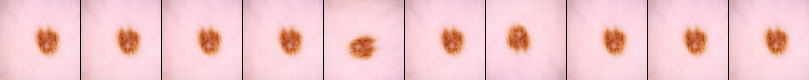

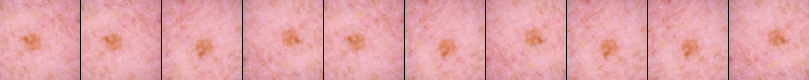

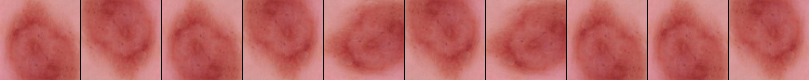

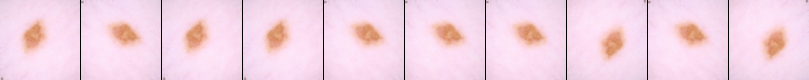

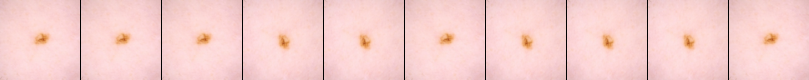

In [8]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_rotate(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Crop augmentation

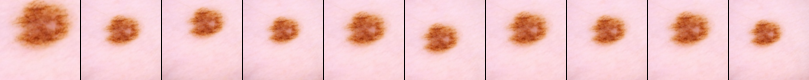

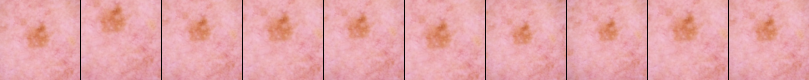

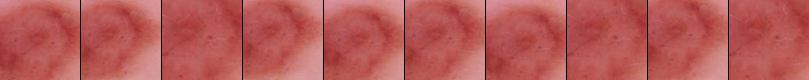

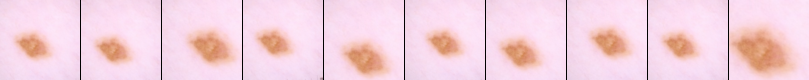

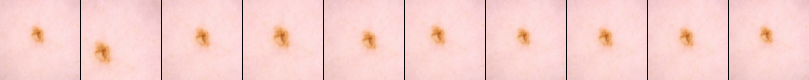

In [9]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_crop(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Rotation augmentation

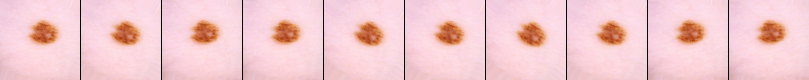

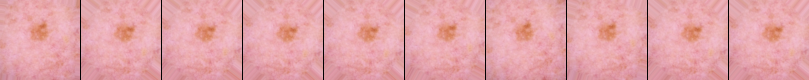

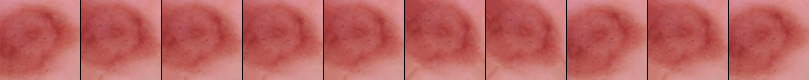

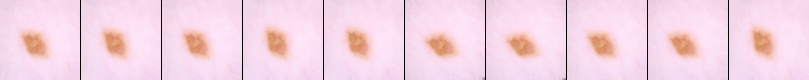

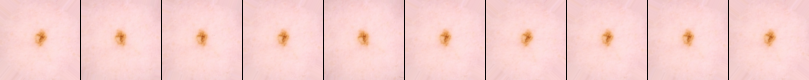

In [10]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_rotation(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Shift augmentation

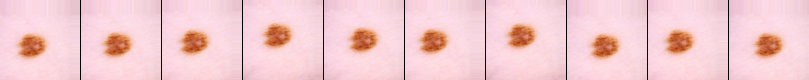

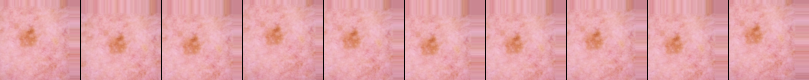

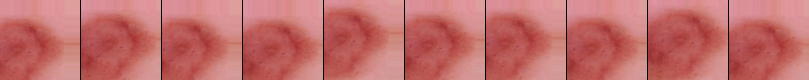

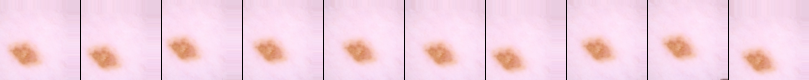

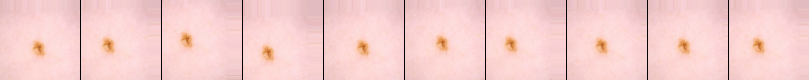

In [11]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_shift(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Shear augmentation

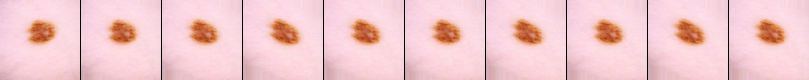

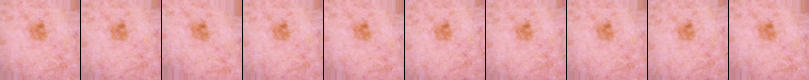

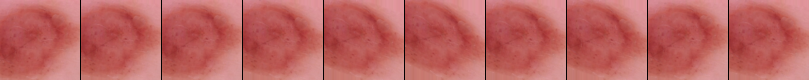

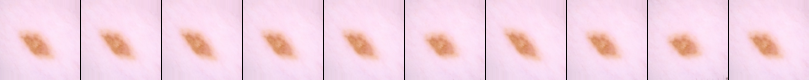

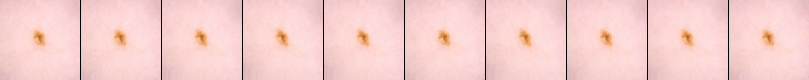

In [12]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_shear(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Saturation augmentation

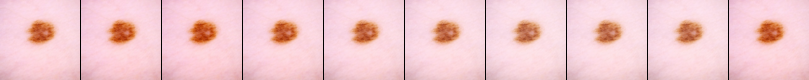

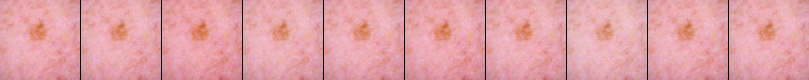

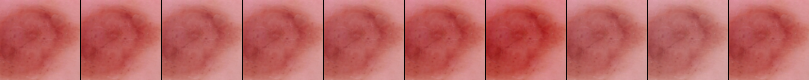

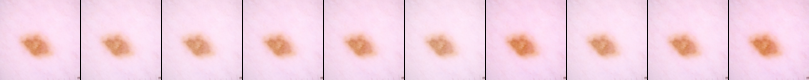

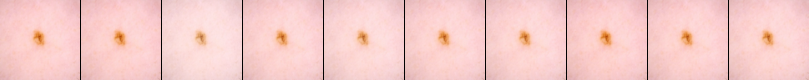

In [13]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_saturation(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Contrast augmentation

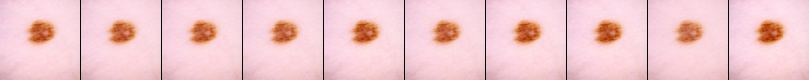

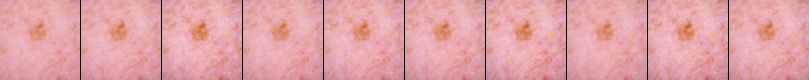

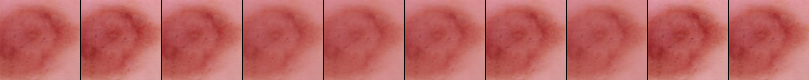

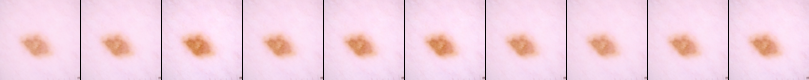

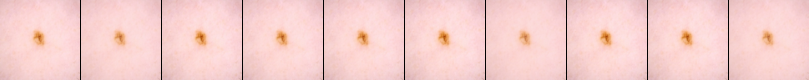

In [14]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_contrast(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Brightness augmentation

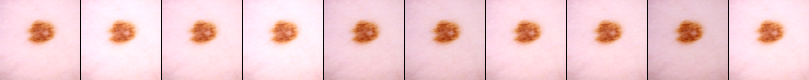

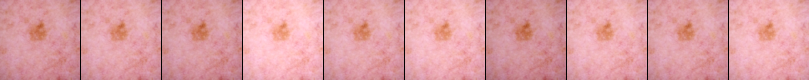

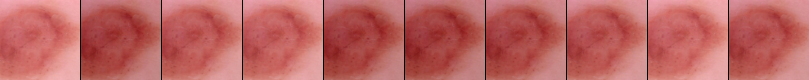

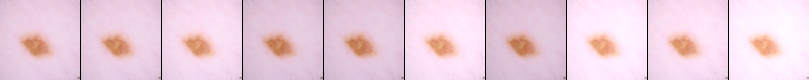

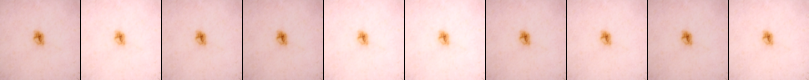

In [15]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_brightness(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# Cutout augmentation

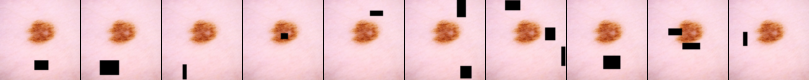

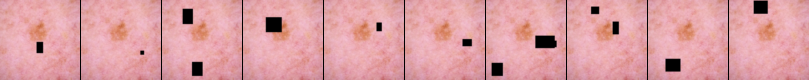

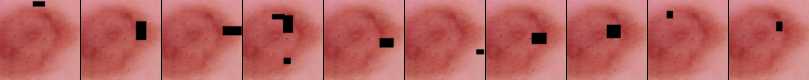

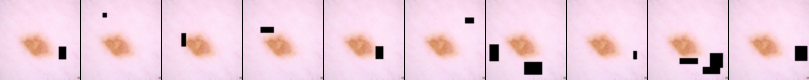

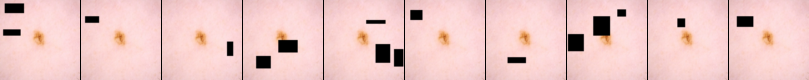

In [16]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment_cutout(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)

# All augmentations

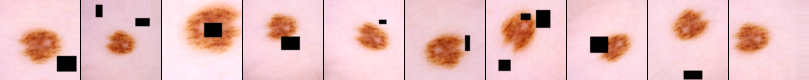

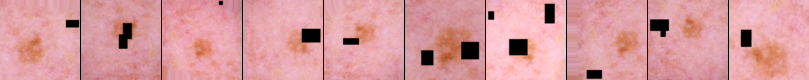

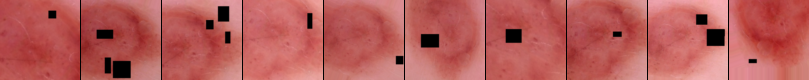

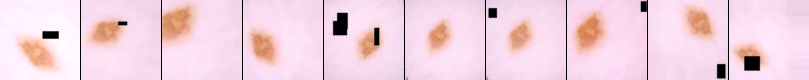

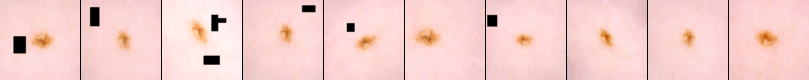

In [17]:
all_elements = iter(get_display_dataset(TRAINING_FILENAMES).unbatch())
for sample in range(config['AUGMENTED_SAMPLES']):
    element = tf.data.Dataset.from_tensors(next(all_elements))
    ds = element.take(1).repeat().map(lambda img: (data_augment(img)))
    ds = ds.take(config['COLUMNS'])
    show_dataset(80, config['COLUMNS'], 1, ds)